In [2]:
# Cell 1: Setup, Imports and Drive Mount
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Set up base directory paths (Adjust to your actual paths if they differ)
import os
BASE_DIR = '/content/drive/MyDrive/cheque_fraud'
RAW_DIR = os.path.join(BASE_DIR, 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
print("Base directory:", BASE_DIR)
print("Raw data directory:", RAW_DIR)
print("Processed data directory:", PROCESSED_DIR)
print("Models directory:", MODELS_DIR)
# Core Libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
print("Setup complete.")

Mounted at /content/drive
Base directory: /content/drive/MyDrive/cheque_fraud
Raw data directory: /content/drive/MyDrive/cheque_fraud/raw
Processed data directory: /content/drive/MyDrive/cheque_fraud/processed
Models directory: /content/drive/MyDrive/cheque_fraud/models
Setup complete.


Listing some files in each raw dataset folder:
hf_subset_10k has 3000 image files
Displaying one sample from hf_subset_10k:


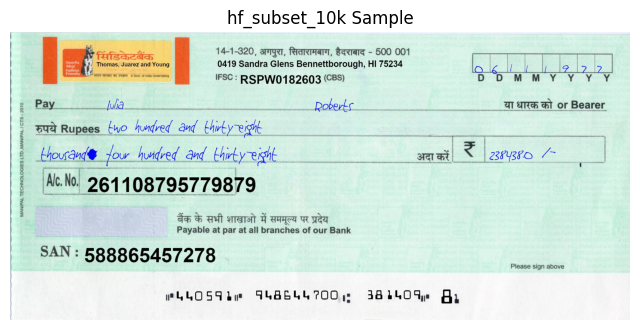

idrbt folder has 112 image files
Displaying one sample from idrbt:


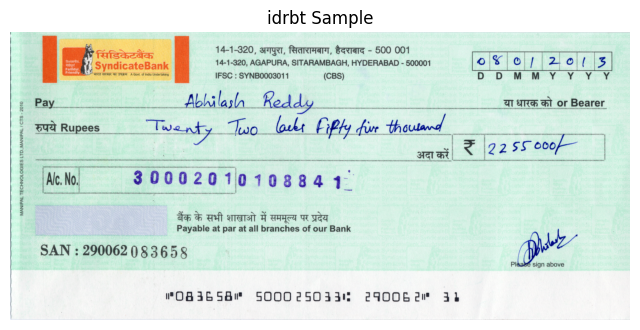

signatures folder has 0 signature image files


In [3]:
# Cell 2: Explore Raw Data - List sample files and display images
# Function to display a sample image
def display_image(path, title="Image"):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 4))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()
print("Listing some files in each raw dataset folder:")
# 1. hf_subset_10k
hf_folder = os.path.join(RAW_DIR, 'hf_subset_10k')
hf_files = glob.glob(hf_folder + '/**/*.png', recursive=True)
print(f"hf_subset_10k has {len(hf_files)} image files")
if len(hf_files) > 0:
    print("Displaying one sample from hf_subset_10k:")
    display_image(hf_files[9], title="hf_subset_10k Sample")
# 2. idrbt dataset
idrbt_folder = os.path.join(RAW_DIR, 'idrbt')
idrbt_files = glob.glob(idrbt_folder + '/**/*.jpg', recursive=True)
print(f"idrbt folder has {len(idrbt_files)} image files")
if len(idrbt_files) > 0:
    print("Displaying one sample from idrbt:")
    display_image(idrbt_files[4], title="idrbt Sample")
# 3. signatures dataset
sign_folder = os.path.join(RAW_DIR, 'signatures')
sign_files = glob.glob(sign_folder + '/**/*.png', recursive=True)
print(f"signatures folder has {len(sign_files)} signature image files")
if len(sign_files) > 0:
    print("Displaying one sample signature:")
    display_image(sign_files[0], title="Signature Sample")

Found 10 bank folders in signatures dataset:
['Attihari', 'Axis', 'Banque', 'Biat', 'Canara', 'Credit', 'HSBC', 'ICICI', 'Saudi', 'universelle']

Bank: Attihari has 50 signature images.


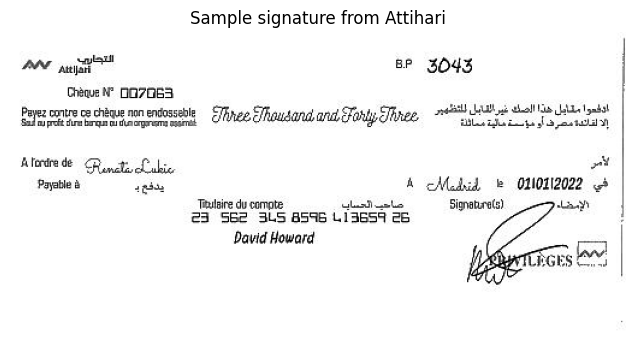


Bank: Axis has 50 signature images.


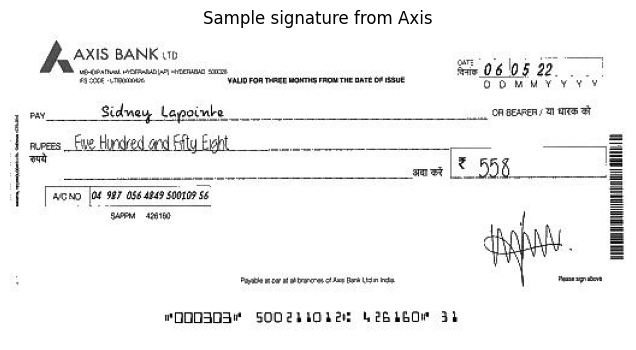


Bank: Banque has 50 signature images.


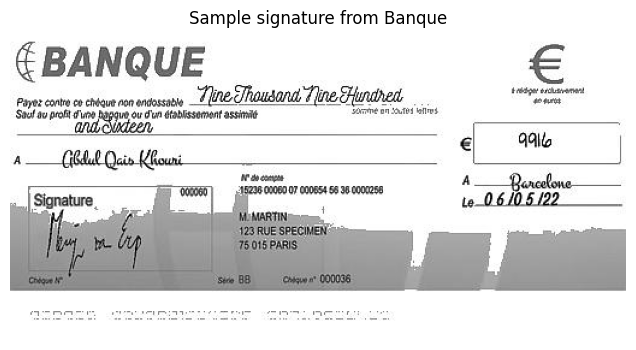


Bank: Biat has 50 signature images.


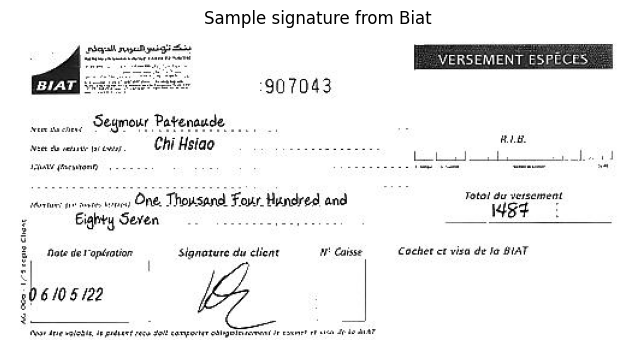


Bank: Canara has 50 signature images.


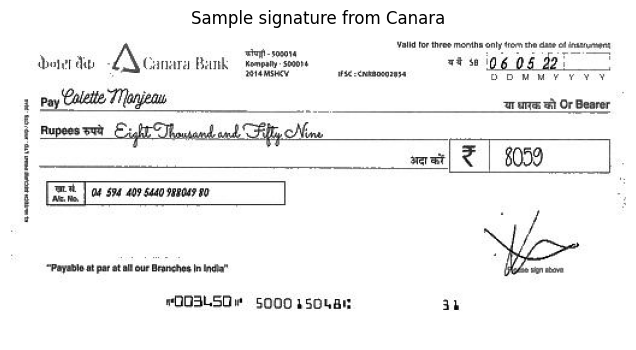


Bank: Credit has 50 signature images.


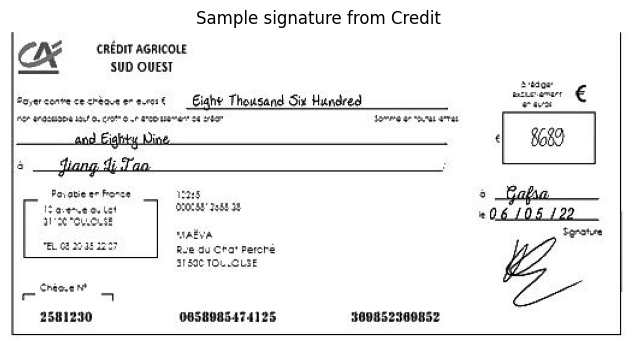


Bank: HSBC has 50 signature images.


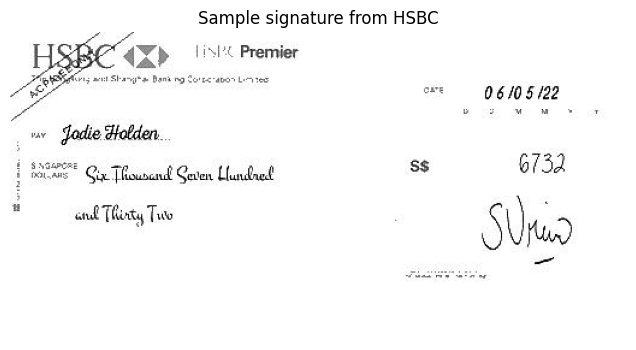


Bank: ICICI has 50 signature images.


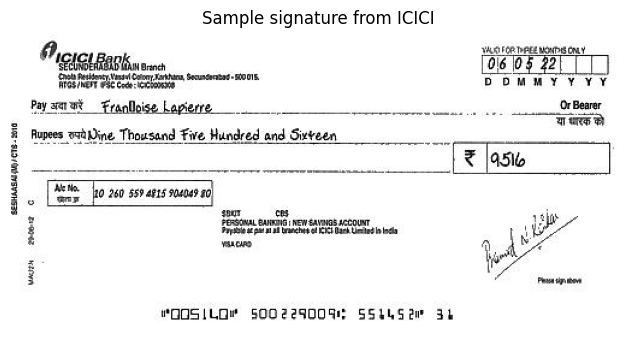


Bank: Saudi has 50 signature images.


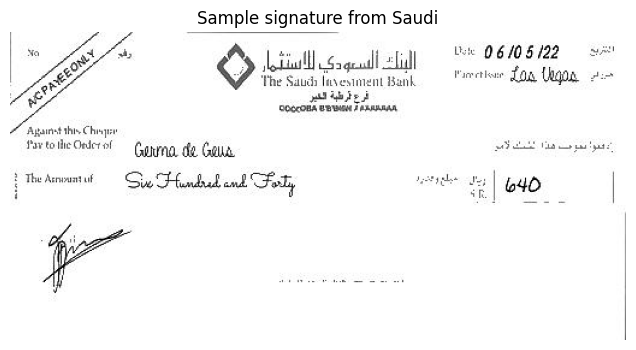


Bank: universelle has 50 signature images.


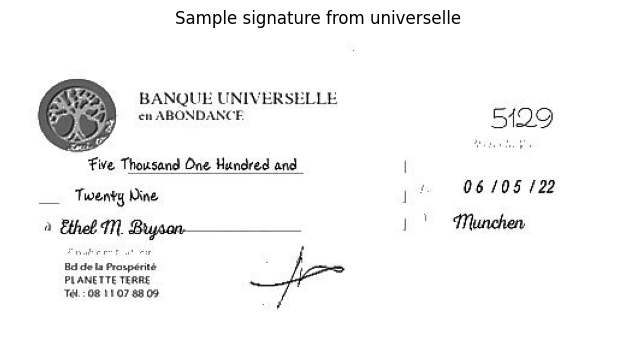

In [4]:
# Cell 5: Explore signatures folder by bank and display samples
signatures_dir = os.path.join(RAW_DIR, 'signatures')
# List all bank folders inside signatures
bank_folders = [f for f in os.listdir(signatures_dir) if os.path.isdir(os.path.join(signatures_dir, f))]
print(f"Found {len(bank_folders)} bank folders in signatures dataset:")
print(bank_folders)
import random
# Display count and a sample image from each bank folder
for bank in bank_folders:
    bank_path = os.path.join(signatures_dir, bank)
    sig_images = glob.glob(bank_path + '/*.png') + glob.glob(bank_path + '/*.jpg')
    print(f"\nBank: {bank} has {len(sig_images)} signature images.")
    if len(sig_images) > 0:
        # Display a random sample signature image
        sample_path = random.choice(sig_images)
        display_image(sample_path, title=f"Sample signature from {bank}")

In [5]:
# Cell 6: Parse IDRBT label file and create a DataFrame for object detection
import pandas as pd
label_file_path = os.path.join(RAW_DIR, 'idrbt', 'train_labels.txt')
data = []
# Assuming the annotation format per line:
# <image_path> <label_id> <xmin> <ymin> <xmax> <ymax>
with open(label_file_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line == '':
            continue
        parts = line.split()
        if len(parts) == 6:
            img_path, label_id, xmin, ymin, xmax, ymax = parts
            data.append({
                'image_path': img_path,
                'label_id': int(label_id),
                'xmin': int(float(xmin)),
                'ymin': int(float(ymin)),
                'xmax': int(float(xmax)),
                'ymax': int(float(ymax))
            })
df_labels = pd.DataFrame(data)
print(f"Parsed {len(df_labels)} annotation entries.")
# Display first few rows to inspect
df_labels.head()

Parsed 0 annotation entries.


""


In [6]:
# Cell 7: Load signatures dataset and prepare labeled data list
import os
signatures_dir = os.path.join(RAW_DIR, 'signatures')
# Each bank folder is a class label
bank_folders = [f for f in os.listdir(signatures_dir) if os.path.isdir(os.path.join(signatures_dir, f))]
print(f"Total banks/classes found: {len(bank_folders)} -> {bank_folders}")
data = []
label_map = {bank: idx for idx, bank in enumerate(bank_folders)}
for bank in bank_folders:
    bank_path = os.path.join(signatures_dir, bank)
    sig_images = glob.glob(bank_path + '/*.png') + glob.glob(bank_path + '/*.jpg')
    for img_file in sig_images:
        data.append({
            'image_path': img_file,
            'label': label_map[bank],
            'bank': bank
        })
print(f"Total signature images loaded: {len(data)}")
# Example output check
for i in range(5):
    print(data[i])

Total banks/classes found: 10 -> ['Attihari', 'Axis', 'Banque', 'Biat', 'Canara', 'Credit', 'HSBC', 'ICICI', 'Saudi', 'universelle']
Total signature images loaded: 500
{'image_path': '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7059.jpg', 'label': 0, 'bank': 'Attihari'}
{'image_path': '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7052.jpg', 'label': 0, 'bank': 'Attihari'}
{'image_path': '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7050.jpg', 'label': 0, 'bank': 'Attihari'}
{'image_path': '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7057.jpg', 'label': 0, 'bank': 'Attihari'}
{'image_path': '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7055.jpg', 'label': 0, 'bank': 'Attihari'}


In [7]:
# Cell 8: Create signature image pairs with labels for Siamese training

import random

# Group images by label (bank)
from collections import defaultdict
images_by_label = defaultdict(list)
for item in data:
    images_by_label[item['label']].append(item['image_path'])
pairs = []
pair_labels = []
# Generate positive pairs (same label)
for label, imgs in images_by_label.items():
    for i in range(len(imgs) - 1):
        pairs.append((imgs[i], imgs[i+1]))
        pair_labels.append(1)
# Generate negative pairs (different labels)
all_labels = list(images_by_label.keys())
for _ in range(len(pairs)):  # generate equal number of negative samples
    label_a = random.choice(all_labels)
    label_b = random.choice(all_labels)
    while label_b == label_a:
        label_b = random.choice(all_labels)
    img_a = random.choice(images_by_label[label_a])
    img_b = random.choice(images_by_label[label_b])
    pairs.append((img_a, img_b))
    pair_labels.append(0)
print(f"Total pairs created: {len(pairs)}")
print(f"Example pairs with labels:")
for i in range(5):
    print(pairs[i], pair_labels[i])

Total pairs created: 980
Example pairs with labels:
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7059.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7052.jpg') 1
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7052.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7050.jpg') 1
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7050.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7057.jpg') 1
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7057.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7055.jpg') 1
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7055.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7054.jpg') 1


In [8]:
import numpy as np
# Shuffle pairs and labels together
indices = np.arange(len(pairs))
np.random.shuffle(indices)
pairs_shuffled = [pairs[i] for i in indices]
labels_shuffled = [pair_labels[i] for i in indices]
print("Example pairs after shuffling:")
for i in range(10):
    print(pairs_shuffled[i], labels_shuffled[i])

Example pairs after shuffling:
('/content/drive/MyDrive/cheque_fraud/raw/signatures/ICICI/Copy of 5360.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Saudi/Copy of 6371.jpg') 0
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Credit/Copy of 1003.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/ICICI/Copy of 5146.jpg') 0
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7646.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Attihari/Copy of 7647.jpg') 1
('/content/drive/MyDrive/cheque_fraud/raw/signatures/universelle/Copy of 9398.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/universelle/Copy of 9394.jpg') 1
('/content/drive/MyDrive/cheque_fraud/raw/signatures/universelle/Copy of 9392.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Axis/Copy of 9.jpg') 0
('/content/drive/MyDrive/cheque_fraud/raw/signatures/Biat/Copy of 8440.jpg', '/content/drive/MyDrive/cheque_fraud/raw/signatures/Biat/Copy of 8439.jpg') 1
('/conte

In [9]:
# Cell 10: Define PyTorch Dataset and DataLoader for signature pairs
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
class SignaturePairsDataset(Dataset):
    def __init__(self, pairs, labels, transform=None):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]
        img1 = Image.open(img1_path).convert('L')  # grayscale
        img2 = Image.open(img2_path).convert('L')
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), torch.tensor([label], dtype=torch.float32)
# Transformations: Resize + ToTensor + Normalize
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Create dataset and dataloader with batch size 32 (adjust as per your RAM)
dataset = SignaturePairsDataset(pairs_shuffled, labels_shuffled, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# Test iteration
examples = next(iter(dataloader))
(img1_batch, img2_batch), labels_batch = examples  # unpack the tuple
print(f"Batch of image1 shape: {img1_batch.shape}")
print(f"Batch of image2 shape: {img2_batch.shape}")
print(f"Batch of labels shape: {labels_batch.shape}")

Batch of image1 shape: torch.Size([32, 1, 100, 100])
Batch of image2 shape: torch.Size([32, 1, 100, 100])
Batch of labels shape: torch.Size([32, 1])


In [10]:
# Cell 11: Define Siamese Network
import torch.nn as nn
import torch.nn.functional as F
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 10 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1)  # output similarity score
        )
    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [11]:
# Cell 12: Contrastive Loss and distance function
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function from Hadsell-et-al.'06
    L = 0.5 * (label) * (distance)^2 + 0.5 * (1-label) * {max(margin - distance, 0)}^2
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        # Euclidean distance between embeddings
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (label) * torch.pow(euclidean_distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive
# Utility function to compute similarity (Euclidean distance)
def compute_distance(output1, output2):
    # For a batch, returns vector of distances between pairs
    return F.pairwise_distance(output1, output2)
print("ContrastiveLoss class and compute_distance function defined.")

ContrastiveLoss class and compute_distance function defined.


In [18]:
# Cell 13: Training loop for Siamese Network
import torch.optim as optim
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 50  # you can increase this based on your compute
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, ((img1, img2), labels) in enumerate(dataloader):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
print("Training completed.")

Epoch [1/50], Loss: 0.3877
Epoch [2/50], Loss: 0.3534
Epoch [3/50], Loss: 0.3508
Epoch [4/50], Loss: 0.3392
Epoch [5/50], Loss: 0.3380
Epoch [6/50], Loss: 0.3324
Epoch [7/50], Loss: 0.3360
Epoch [8/50], Loss: 0.3274
Epoch [9/50], Loss: 0.3270
Epoch [10/50], Loss: 0.3251
Epoch [11/50], Loss: 0.3324
Epoch [12/50], Loss: 0.3217
Epoch [13/50], Loss: 0.3237
Epoch [14/50], Loss: 0.3196
Epoch [15/50], Loss: 0.3191
Epoch [16/50], Loss: 0.3252
Epoch [17/50], Loss: 0.3184
Epoch [18/50], Loss: 0.3214
Epoch [19/50], Loss: 0.3169
Epoch [20/50], Loss: 0.3241
Epoch [21/50], Loss: 0.3140
Epoch [22/50], Loss: 0.3215
Epoch [23/50], Loss: 0.3117
Epoch [24/50], Loss: 0.3155
Epoch [25/50], Loss: 0.3075
Epoch [26/50], Loss: 0.3125
Epoch [27/50], Loss: 0.3152
Epoch [28/50], Loss: 0.3141
Epoch [29/50], Loss: 0.3068
Epoch [30/50], Loss: 0.3036
Epoch [31/50], Loss: 0.3009
Epoch [32/50], Loss: 0.3048
Epoch [33/50], Loss: 0.2986
Epoch [34/50], Loss: 0.3020
Epoch [35/50], Loss: 0.2982
Epoch [36/50], Loss: 0.2984
E

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.91MB/s]


Epoch [1/5] Train Loss: 0.2664 Train Acc: 0.5137 Val Loss: 0.2618 Val Acc: 0.4908
Epoch [2/5] Train Loss: 0.2632 Train Acc: 0.5052 Val Loss: 0.2632 Val Acc: 0.5020
Epoch [3/5] Train Loss: 0.2620 Train Acc: 0.5054 Val Loss: 0.2598 Val Acc: 0.5022
Epoch [4/5] Train Loss: 0.2609 Train Acc: 0.5046 Val Loss: 0.2606 Val Acc: 0.5021
Epoch [5/5] Train Loss: 0.2609 Train Acc: 0.5058 Val Loss: 0.2607 Val Acc: 0.5010
Training complete.
Validation Precision: 0.5008
Validation Recall:    0.5024
Validation F1 Score:  0.5016


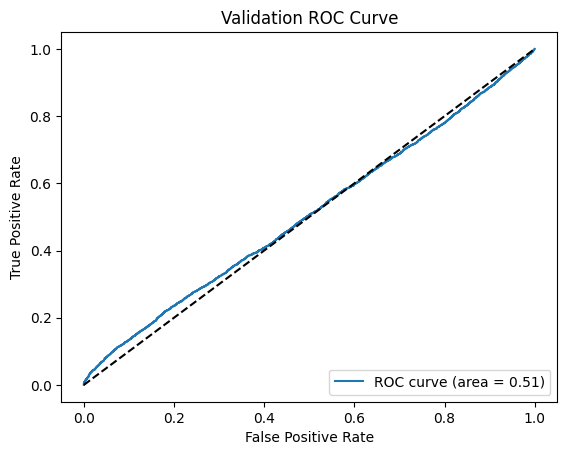

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import random
# -------------------------
# Siamese Dataset
# -------------------------
class SiameseDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, index):
        img1, label1 = self.dataset[index]
        # 50% chance same class, 50% different class
        if random.randint(0, 1):
            # same class
            while True:
                img2, label2 = random.choice(self.dataset)
                if label1 == label2:
                    label = 1
                    break
        else:
            # different class
            while True:
                img2, label2 = random.choice(self.dataset)
                if label1 != label2:
                    label = 0
                    break
        return (img1, img2), torch.tensor(label, dtype=torch.float32)
    def __len__(self):
        return len(self.dataset)
# -------------------------
# Siamese Network
# -------------------------
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128)
        )
    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    def forward(self, input1, input2):
        out1 = self.forward_once(input1)
        out2 = self.forward_once(input2)
        return out1, out2
# -------------------------
# Contrastive Loss
# -------------------------
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, out1, out2, label):
        distances = F.pairwise_distance(out1, out2)
        loss = torch.mean((1 - label) * torch.pow(distances, 2) +
                          label * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2))
        return loss
# -------------------------
# Data Preparation
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
siamese_dataset = SiameseDataset(mnist_dataset)
train_size = int(0.8 * len(siamese_dataset))
val_size = len(siamese_dataset) - train_size
train_dataset, val_dataset = random_split(siamese_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# -------------------------
# Training Loop
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
def compute_accuracy(distances, labels, threshold=0.5):
    preds = (distances < threshold).float()
    correct = (preds == labels.view_as(preds)).sum().item()
    return correct / len(labels)
num_epochs = 5  # reduce for quick testing
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for (img1, img2), labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        distances = F.pairwise_distance(output1, output2)
        acc = compute_accuracy(distances, labels)
        correct_train += acc * len(labels)
        total_train += len(labels)
    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train if total_train > 0 else 0
    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for (img1, img2), labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            out1, out2 = model(img1, img2)
            val_loss = criterion(out1, out2, labels)
            running_val_loss += val_loss.item()
            distances = F.pairwise_distance(out1, out2)
            acc_val = compute_accuracy(distances, labels)
            correct_val += acc_val * len(labels)
            total_val += len(labels)
    val_loss = running_val_loss / len(val_loader)
    val_acc = correct_val / total_val if total_val > 0 else 0
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
print("Training complete.")

# -------------------------
# Evaluation & Metrics
# -------------------------
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
model.eval()
all_labels = []
all_distances = []
with torch.no_grad():
    for (img1, img2), labels in val_loader:
        img1, img2 = img1.to(device), img2.to(device)
        out1, out2 = model(img1, img2)
        distances = F.pairwise_distance(out1, out2)
        all_distances.extend(distances.cpu().numpy())
        all_labels.extend(labels.numpy().flatten())
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_distances = np.array(all_distances)
# Choose threshold (tune if needed)
threshold = 0.5
preds = (all_distances < threshold).astype(int)
# Compute Metrics
precision = precision_score(all_labels, preds)
recall = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall:    {recall:.4f}')
print(f'Validation F1 Score:  {f1:.4f}')
# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, -all_distances)  # negative distances = similarity
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc='lower right')
plt.show()

Validation Precision: 0.4976
Validation Recall:    0.5113
Validation F1 Score:  0.5044


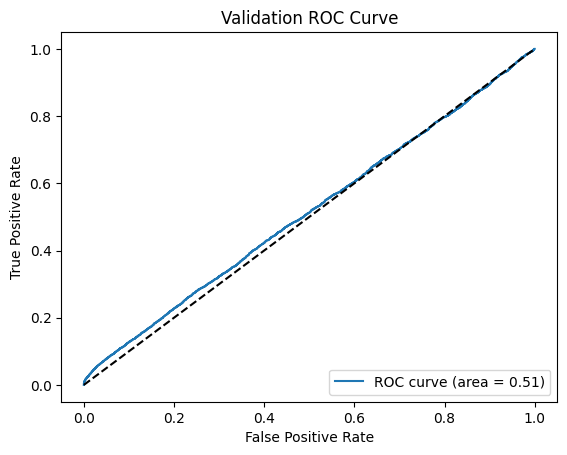

In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F
model.eval()
all_labels = []
all_distances = []
with torch.no_grad():
    for (img1, img2), labels in val_loader:
        img1, img2 = img1.to(device), img2.to(device)
        out1, out2 = model(img1, img2)
        distances = F.pairwise_distance(out1, out2)
        all_distances.extend(distances.cpu().numpy())
        all_labels.extend(labels.numpy().flatten())
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_distances = np.array(all_distances)
# Choose threshold (e.g., 0.5) or tune to optimize your metric
threshold = 0.5
preds = (all_distances < threshold).astype(int)
# Compute Metrics
precision = precision_score(all_labels, preds)
recall = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall:    {recall:.4f}')
print(f'Validation F1 Score:  {f1:.4f}')
# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, -all_distances)  # negative distances for similarity
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
from PIL import Image
import torch
import torch.nn.functional as F
# Use the same transform used during training (without augmentation)
inference_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
def infer_signature_pair(model, img_path1, img_path2, threshold=0.5, device=device):
    model.eval()
    img1 = Image.open(img_path1).convert('L')
    img2 = Image.open(img_path2).convert('L')
    img1 = inference_transform(img1).unsqueeze(0).to(device)
    img2 = inference_transform(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        out1, out2 = model(img1, img2)
        distance = F.pairwise_distance(out1, out2).item()
    match = distance < threshold
    return match, distance
# Example usage:
# match, dist = infer_signature_pair(model, 'path/to/sign1.png', 'path/to/sign2.png')
# print(f"Match: {match}, Distance: {dist:.4f}")

In [16]:
import torch
# Save the trained model weights
torch.save(model.state_dict(), "siamese_signature_model.pth")
# If you also want to save full model (not recommended usually)
# torch.save(model, "siamese_signature_model_full.pth")

In [17]:
from google.colab import drive
drive.mount('/content/drive')
# Copy to drive
!cp siamese_signature_model.pth /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
